In [1]:
# Import statements:

import datetime
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Overview

Data is queried from the neo4j database containing the LDN dataset of the Swift ecosystem: https://doi.org/10.5281/zenodo.6376008

For each csv file used in the following analysis the cypher query used to query the database is listed as well. 

Overall the database contains the following nodes: 
- Project (project inclucing repository information)
- App (an analysed project version)
- Library (library version that was referenced from a resolution file of a library)
- LibraryDependency (library version that was referenced from a manifest file of a library)
- Vulnerability (vulnerability queried from NVD)

The above nodes are connected with the following relationships
- (Project)-[:HAS APP]->(App)
- (App)-[:IS]->(Library)
- (App)-[:DEPENDS ON]->(Library)
- (App)-[:DEPENDS ON]->(LibraryDefinition)
- (Library)-[:HAS VULNERABILITY]->(Vulnerability)

This notebook how analysis for the article "Analysis of Dependency Networks of Package Managers Used in iOS Development" was carried out and makes it easy to replicate the results. The csv files used are provided with the notebook but can also be queried from the neo4j database using the queries listed. 

The following notebook is divided into three chapters: RQ1, RQ2 and RQ3. 

- RQ1: How has the combined LDN of the Swift ecosystem evolved? 
- RQ2: How have the LDNs of each of the package manager evolved? 
- RQ3: How has the number of dependencies evolved in the LDNs? 

## RQ1: How has the combined LDN of the Swift ecosystem evolved?  

First we plot the cumulative number of libraries and library versions over time. 

First to retreive information on libraries added we read in a csv file with information on first occurrence of libraries. Used query: 
   
    match 
        (app:App) 
    where 
        not (:App)-[:CHANGED_TO]->(app) 
    return 
        distinct app.name as name, 
        app.tag as tag, 
        app.timestamp as timestamp

In [2]:
firsts = pd.read_csv('all-firsts.csv')

In [3]:
firsts['date'] = firsts['timestamp'].apply(datetime.datetime.fromtimestamp)
firsts['month'] = firsts['date'].dt.to_period('M')
firsts['year'] = firsts['date'].dt.to_period('Y')

firsts = firsts[firsts['year'] != '2022']

First to retreive information on libraries added we read in a csv file with information on first occurrence of libraries. Used query: 
   
    match 
        (app:App) 
    where 
        not (:App)-[:CHANGED_TO]->(app) 
    return 
        distinct app.name as name, 
        app.tag as tag, 
        app.timestamp as timestamp

In [4]:
dep_no_type = pd.read_csv('dependencies_no_type.csv')
dep_no_type.columns

Index(['library_name', 'tag', 'timestamp', 'dependency_count',
       'dependent_count'],
      dtype='object')

In [5]:
dep_no_type.head()

,library_name,tag,timestamp,dependency_count,dependent_count
0,apple/swift-tools-support-core,0.1.5,1592329769,0,1
1,apple/swift-package-manager,swift-DEVELOPMENT-SNAPSHOT-2019-08-29-a,1567051400,0,0
2,apple/swift-package-manager,swift-DEVELOPMENT-SNAPSHOT-2019-08-30-a,1567106747,0,0
3,apple/swift-package-manager,swift-DEVELOPMENT-SNAPSHOT-2019-09-04-a,1567616418,0,0
4,apple/swift-tools-support-core,0.1.6,1593551967,0,0


Parsing timestamp as date and calculating both month and year periods so that data can be filtered more easily.

In [6]:
dep_no_type['date'] = dep_no_type['timestamp'].apply(datetime.datetime.fromtimestamp)
dep_no_type['month'] = dep_no_type['date'].dt.to_period('M')
dep_no_type['year'] = dep_no_type['date'].dt.to_period('Y')

dep_no_type = dep_no_type[dep_no_type['year'] != '2022']

The following query finds all connected library versions and returns for each version the library name, tag, timestamp of when the library version was first referenced in the package manager and the package manager name. 

    match 
        (p:Project)-[:HAS_APP]->(a:App)
    optional 
        match (a)-[r:DEPENDS_ON]->(l:Library)<-[:IS]-(:App)
    with 
        a, 
        r.type as type
    optional match 
        (a)-[:IS]->(l:Library)<-[r:DEPENDS_ON]-(dapp:App) 
    where 
        type is null or type = r.type
    with 
        a, 
        COALESCE(r.type, type) as type, 
        dapp
    with 
        a, 
        type, 
        min(toInteger(dapp.timestamp)) as timestamp
    return 
        a.name as library_name, 
        a.tag as tag, 
        case when a.timestamp > timestamp then timestamp else a.timestamp end as timestamp,
        type

In [7]:
versions = pd.read_csv('required_library_versions_original_timestamp.csv')

In [8]:
versions['date'] = versions['timestamp'].apply(datetime.datetime.fromtimestamp)
versions['month'] = versions['date'].dt.to_period('M')
versions['year'] = versions['date'].dt.to_period('Y')

Plotting the cumulative number of libraries and library versions:

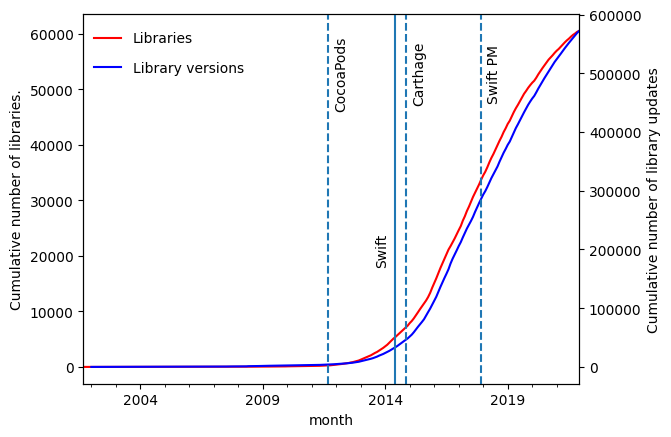

In [9]:
ax = firsts.groupby(['month']).size().cumsum().plot(color='r')

ax2 = dep_no_type[dep_no_type['year'].between('2002.01.01', '2021.12.31')].groupby(['month']).size().cumsum().plot(secondary_y=True,color='b', ax=ax)

plt.xlabel("Year")

ax.set_ylabel('Cumulative number of libraries.')
ax2.set_ylabel('Cumulative number of library updates')

ax.legend(['Libraries'], loc=(.01,.9), frameon = False)
ax2.legend(['Library versions'], loc=(.01,.82), frameon = False)

cocoa_time = pd.Period('2011-09', 'M')
plt.axvline(cocoa_time, linestyle='--')
plt.text(cocoa_time + pd.offsets.MonthEnd(3), 500000, "CocoaPods", rotation=90, verticalalignment='center')

carthage_time = pd.Period('2014-11', 'M')
plt.axvline(carthage_time, linestyle='--')
plt.text(carthage_time + pd.offsets.MonthEnd(3), 500000, "Carthage", rotation=90, verticalalignment='center')

swift_time = pd.Period('2014-06', 'M')
plt.axvline(swift_time, linestyle='-')
plt.text(swift_time - pd.offsets.MonthEnd(10), 200000, "Swift", rotation=90, verticalalignment='center')

swiftpm_time = pd.Period('2017-12', 'M')
plt.axvline(swiftpm_time, linestyle='--')
plt.text(swiftpm_time + pd.offsets.MonthEnd(3), 500000, "Swift PM", rotation=90, verticalalignment='center')
plt.tight_layout


plt.savefig('plot_number_of_libraries_cumulative_both.pdf', bbox_inches = "tight")

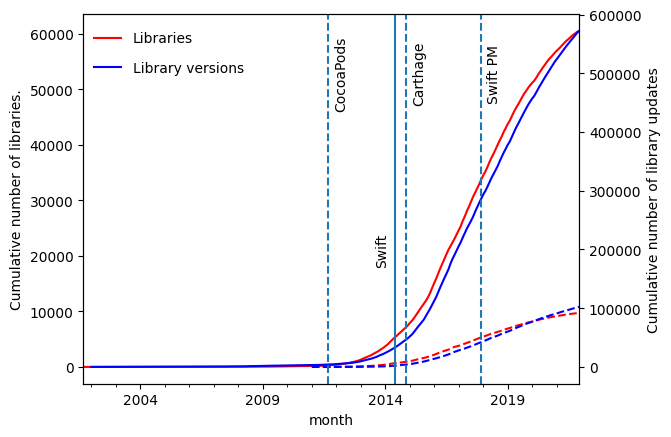

In [10]:
# including required libraries

ax = firsts.groupby(['month']).size().cumsum().plot(color='r')

ax2 = dep_no_type[dep_no_type['year'].between('2002.01.01', '2021.12.31')].groupby(['month']).size().cumsum().plot(secondary_y=True,color='b', ax=ax)

versions_all = versions.loc[versions.groupby(['name']).timestamp.idxmin()]
required_data = versions_all[ (versions_all['year'] != '2022')].groupby(['month']).size().cumsum()
ax3 = required_data.plot(ax=ax, linestyle='--', color='r')

versions_all = versions[['name', 'month', 'year', 'timestamp']]
versions_all = versions_all.drop_duplicates()
required_data = versions_all[ (versions_all['year'] != '2022')].groupby(['month']).size().cumsum()

ax4 = required_data.plot(secondary_y=True,ax=ax, linestyle='--', color='b')

plt.xlabel("Year")

ax.set_ylabel('Cumulative number of libraries.')
ax2.set_ylabel('Cumulative number of library updates')

ax.legend(['Libraries'], loc=(.01,.9), frameon = False)
ax2.legend(['Library versions'], loc=(.01,.82), frameon = False)
#ax3.legend(['Required libraries'], loc=(.01,.74), frameon = False)

cocoa_time = pd.Period('2011-09', 'M')
plt.axvline(cocoa_time, linestyle='--')
plt.text(cocoa_time + pd.offsets.MonthEnd(3), 500000, "CocoaPods", rotation=90, verticalalignment='center')

carthage_time = pd.Period('2014-11', 'M')
plt.axvline(carthage_time, linestyle='--')
plt.text(carthage_time + pd.offsets.MonthEnd(3), 500000, "Carthage", rotation=90, verticalalignment='center')

swift_time = pd.Period('2014-06', 'M')
plt.axvline(swift_time, linestyle='-')
plt.text(swift_time - pd.offsets.MonthEnd(10), 200000, "Swift", rotation=90, verticalalignment='center')

swiftpm_time = pd.Period('2017-12', 'M')
plt.axvline(swiftpm_time, linestyle='--')
plt.text(swiftpm_time + pd.offsets.MonthEnd(3), 500000, "Swift PM", rotation=90, verticalalignment='center')
plt.tight_layout


plt.savefig('plot_number_of_libraries_cumulative_both_new.pdf', bbox_inches = "tight")

Plotting new libraries added each month:

Text(0, 0.5, 'Number of new libraries added.')

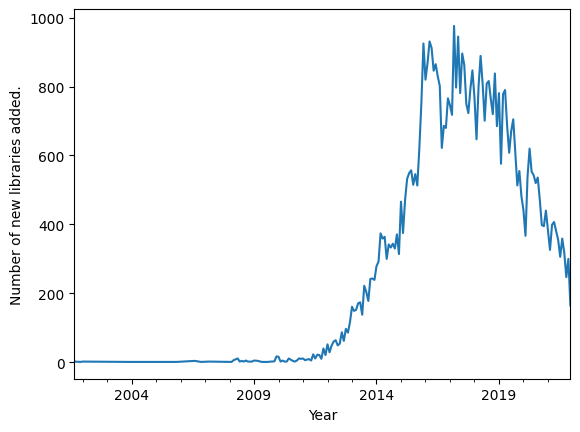

In [11]:
firsts.groupby(['month']).size().plot()

plt.xlabel("Year")
plt.ylabel("Number of new libraries added.")

Text(0, 0.5, 'Number of new library versions added.')

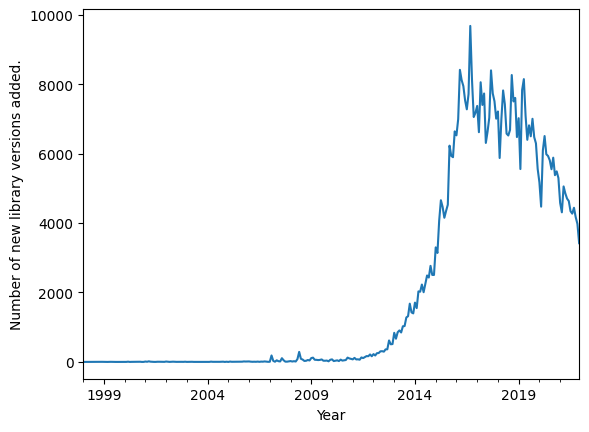

In [12]:
dep_no_type.groupby(['month']).size().plot()

plt.xlabel("Year")
plt.ylabel("Number of new library versions added.")

## RQ2: How have the LDNs of each of the package manager evolved? 

We plot how the number of libraries has evolved. For this we find the first version of each library and plot the cumulative number of libraries over time. 

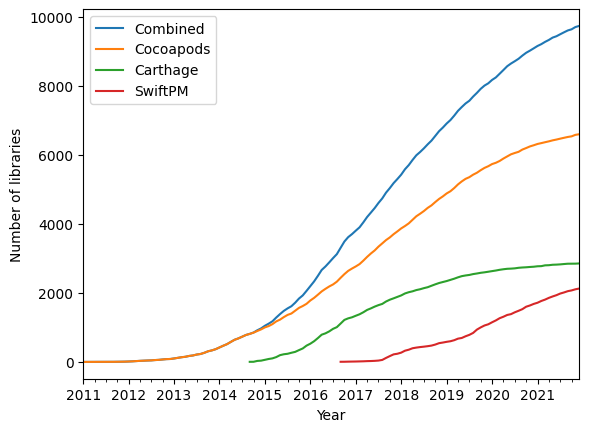

In [13]:
versions_firsts = versions.loc[versions.groupby(['name', 'type']).timestamp.idxmin()]

required_cocoapods = versions_firsts[(versions_firsts['type'] == 'cocoapods')  & (versions_firsts['year'] != '2022')].groupby(['month']).size().cumsum()
required_carthage = versions_firsts[(versions_firsts['type'] == 'carthage') & (versions_firsts['year'] != '2022')].groupby(['month']).size().cumsum()
required_swiftpm = versions_firsts[(versions_firsts['type'] == 'swiftpm') & (versions_firsts['year'] != '2022')].groupby(['month']).size().cumsum()

versions_all = versions.loc[versions.groupby(['name']).timestamp.idxmin()]
required_data = versions_all[ (versions_all['year'] != '2022')].groupby(['month']).size().cumsum()

results_firsts = pd.DataFrame({'Combined': required_data, 'Cocoapods': required_cocoapods, 'Carthage': required_carthage, 'SwiftPM': required_swiftpm})

results_firsts.plot()
plt.legend(loc='upper left')
plt.xlabel("Year")
plt.ylabel("Number of libraries")
plt.tight_layout

plt.savefig('plot_number_of_libraries_cumulative_per_package_manager.pdf', bbox_inches = "tight")

We plot the cumulative number of library versions over time. 

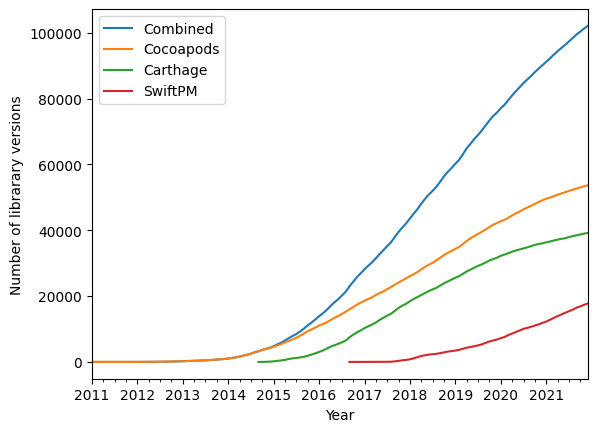

In [14]:
required_cocoapods = versions[(versions['type'] == 'cocoapods')  & (versions['year'] != '2022')].groupby(['month']).size().cumsum()
required_carthage = versions[(versions['type'] == 'carthage') & (versions['year'] != '2022')].groupby(['month']).size().cumsum()
required_swiftpm = versions[(versions['type'] == 'swiftpm') & (versions['year'] != '2022')].groupby(['month']).size().cumsum()

versions_all = versions[['name', 'month', 'year', 'timestamp']]
versions_all = versions_all.drop_duplicates()
required_data = versions_all[ (versions_all['year'] != '2022')].groupby(['month']).size().cumsum()

results_firsts = pd.DataFrame({'Combined': required_data, 'Cocoapods': required_cocoapods, 'Carthage': required_carthage, 'SwiftPM': required_swiftpm})

results_firsts.plot()
plt.legend(loc='upper left')
plt.xlabel("Year")
plt.ylabel("Number of librarary versions")
plt.tight_layout

plt.savefig('plot_number_of_library_updates_cumulative_per_package_manager.pdf', bbox_inches = "tight")

We plot the number of library updates per month: 

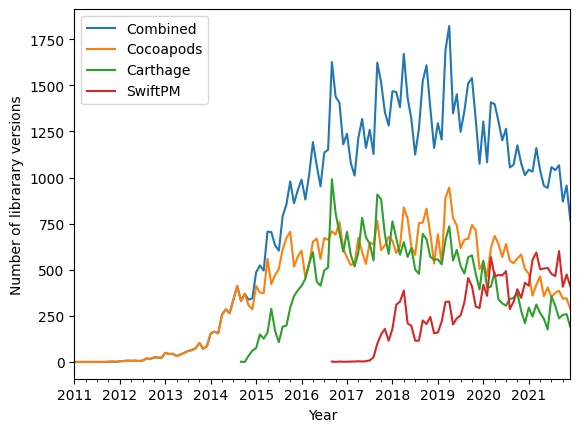

In [15]:
required_cocoapods = versions[(versions['type'] == 'cocoapods')  & (versions['year'] != '2022')].groupby(['month']).size()
required_carthage = versions[(versions['type'] == 'carthage') & (versions['year'] != '2022')].groupby(['month']).size()
required_swiftpm = versions[(versions['type'] == 'swiftpm') & (versions['year'] != '2022')].groupby(['month']).size()

versions_all = versions[['name', 'month', 'year', 'timestamp']]
versions_all = versions_all.drop_duplicates()
required_data = versions_all[ (versions_all['year'] != '2022')].groupby(['month']).size()

results_firsts = pd.DataFrame({'Combined': required_data, 'Cocoapods': required_cocoapods, 'Carthage': required_carthage, 'SwiftPM': required_swiftpm})

results_firsts.plot()
plt.legend(loc='upper left')
plt.xlabel("Year")
plt.ylabel("Number of librarary versions")
plt.tight_layout

plt.savefig('plot_number_of_library_updates_per_month_per_package_manager.pdf',  bbox_inches = "tight")

### Checks done with cocoapods spec library analysis

Reading in coocapods2.csv. This file contains all additions, modifications and deletions of files in the CocoaPods spec respository. 

File was created by running
  
    caffeinate time sh analyse_cocoapods.sh > cocoapods.csv
    
The generated csv file does not include a header, columns are: operation ('A', 'M' or 'D'), file, year and month. Year and month values are integers.

In [26]:
columns = ['operation', 'file', 'year', 'month']
cocoapods = pd.read_csv(r'cocoapods.csv', sep=',', header=0, names=columns)

In [27]:
cocoapods['year_s'] = cocoapods['year'].apply(str)
cocoapods['month_s'] = cocoapods['month'].apply(str)

def toPeriod(value):
    return pd.Period(value, freq='M')

cocoapods.loc[cocoapods.index,'combined'] =  (cocoapods['year_s'] + "-" + cocoapods['month_s']).apply(toPeriod)

/var/folders/6w/7bbpdns15f3_lz9dcrprnwm80000gn/T/ipykernel_14424/2372200411.py:7: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  cocoapods.loc[cocoapods.index,'combined'] =  (cocoapods['year_s'] + "-" + cocoapods['month_s']).apply(toPeriod)


Plotting the number of additions to the Spec repository. Additions of .podspec files are additions of new library versions.

<AxesSubplot: xlabel='combined'>

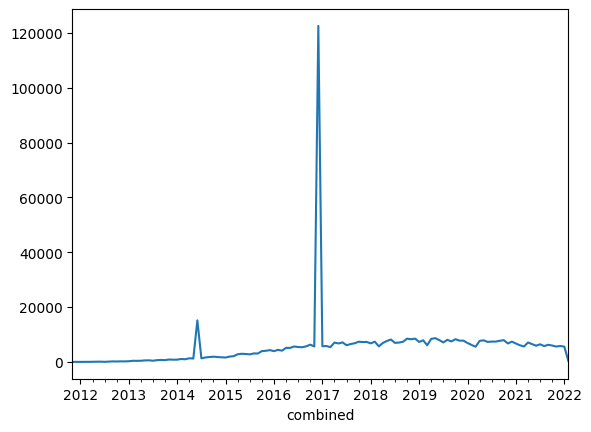

In [28]:
cocoapods[(cocoapods['operation'] == 'A') & (cocoapods['file'].str.contains(".podspec"))].groupby('combined').size().plot()

The number of updates seems to be growing steadily. There are two outliers. 

6.2014 there was a change in naming convention from "500px-iOS-api/1.0.2/500px-iOS-api.podspec.json" to "Specs/500px-iOS-api/1.0.2/500px-iOS-api.podspec.json" and it resulted in 15171 additions.

12.2016 there was a change in naming convention from "Specs/CodeQuickKit/1.0.0/CodeQuickKit.podspec.json" to "Specs/0/0/0/CodeQuickKit/1.0.0/CodeQuickKit.podspec.json" that resulted in 122513 additions.

Plotting the number of addtions again when excluding the two outliers: 

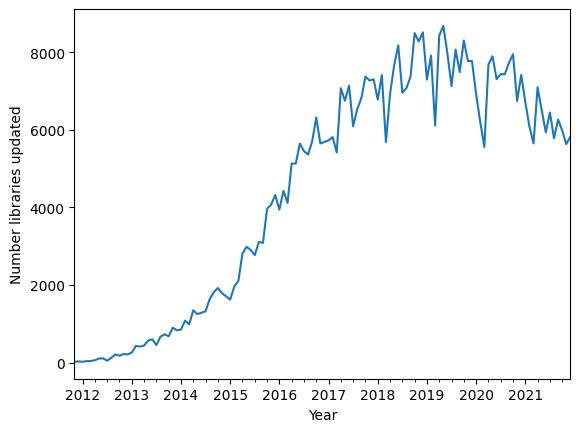

In [29]:
cocoapods[(cocoapods['operation'] == 'A') & (cocoapods['file'].str.contains(".podspec")) 
          & ~((cocoapods['year'] == 2016) & (cocoapods['month'] == 12)) 
          & ~((cocoapods['year'] == 2014) & (cocoapods['month'] == 6)) 
          & (cocoapods['year'] != 2022)].groupby(['combined']).size().plot()

plt.xlabel("Year")
plt.ylabel("Number libraries updated")

plt.savefig('library_updates_cocoapods_repo.pdf')

Extracting names from filenames so that we can see additions of new libraries. 

In [30]:
def find_name(path):
    parts = path.split('/')
    if len(parts) >= 3:
        name = parts[-3]
        return name.strip()
    return ''

cocoapods['name'] = cocoapods['file'].apply(find_name)

In [31]:
len(cocoapods['name'].unique())

85429

In [32]:
cocoapods.sort_values('combined')

,operation,file,year,month,year_s,month_s,combined,name
0,A,AFNetworking/0.7.0/AFNetworking.podspec,2011,11,2011,11,2011-11,AFNetworking
20,M,Reachability/2.0.4/Reachability.podspec,2011,11,2011,11,2011-11,Reachability
21,A,RestKit-JSON-JSONKit/0.9.3/RestKit-JSON-JSONK...,2011,11,2011,11,2011-11,RestKit-JSON-JSONKit
22,A,RestKit-Network/0.9.3/RestKit-Network.podspec,2011,11,2011,11,2011-11,RestKit-Network
23,A,RestKit-ObjectMapping/0.9.3/RestKit-ObjectMap...,2011,11,2011,11,2011-11,RestKit-ObjectMapping
...,...,...,...,...,...,...,...,...
871924,A,Specs/5/0/1/three3d_egl_osx/0.1.1/three3d_egl...,2022,2,2022,2,2022-02,three3d_egl_osx
871923,A,Specs/4/f/c/AgoraAudio_iOS/3.5.2.2/AgoraAudio...,2022,2,2022,2,2022-02,AgoraAudio_iOS
871922,A,Specs/4/d/8/Apptics/1.0.0/Apptics.podspec.json,2022,2,2022,2,2022-02,Apptics
871933,A,Specs/5/9/0/AerisWeather/3.3.2/AerisWeather.p...,2022,2,2022,2,2022-02,AerisWeather


Creating new dataframe with only the first row for each name. 

In [33]:
cocoapods_firsts = cocoapods.drop_duplicates(subset='name', keep='first')

Plotting number of new libraries added each month. Numbers are larger than our analysis, but these also include incorrect and not accessible libraries. 

<AxesSubplot: xlabel='combined'>

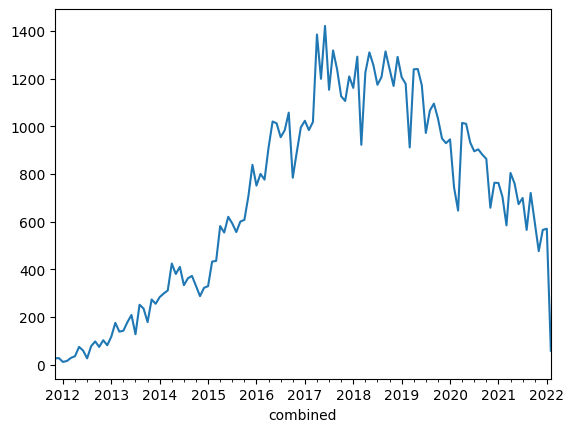

In [34]:
cocoapods_firsts.groupby('combined')['name'].count().plot()

Calculating additions and deletions:

In [35]:
additions = cocoapods[(cocoapods['operation'] == 'A') & (cocoapods['file'].str.contains(".podspec")) 
          & ~((cocoapods['year'] == 2016) & (cocoapods['month'] == 12)) 
          & ~((cocoapods['year'] == 2014) & (cocoapods['month'] == 6)) 
          & (cocoapods['year'] != 2022)].groupby(['combined']).size()
deletions = cocoapods[(cocoapods['operation'] == 'D') & (cocoapods['file'].str.contains(".podspec")) 
          & ~((cocoapods['year'] == 2016) & (cocoapods['month'] == 12)) 
          & ~((cocoapods['year'] == 2014) & (cocoapods['month'] == 6)) 
          & (cocoapods['year'] != 2022)].groupby(['combined']).size()

Plotting deletions, additions and their difference, we see that 
the number of deletions is negligible. 

Text(0, 0.5, 'Cocoapods')

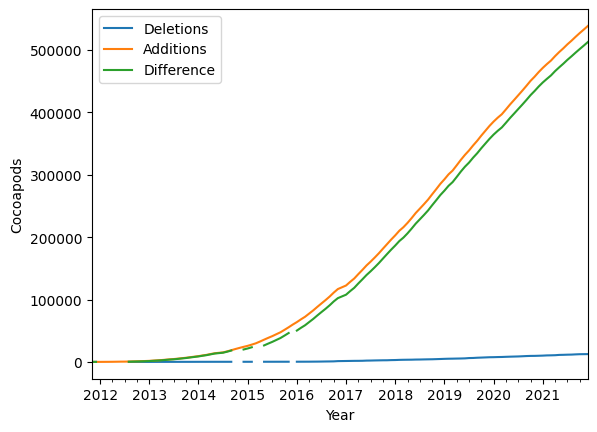

In [36]:
difference = pd.DataFrame({'Deletions': deletions.cumsum(), 'Additions': additions.cumsum(), 'Difference': (additions - deletions).cumsum()})

difference.plot()
plt.legend(loc='upper left')
plt.xlabel("Year")
plt.ylabel("Cocoapods")

## RQ3: How has the number of dependencies evolved in the LDNs?

For RQ3 we calculate snapshots of the library dependency network for each month. For this we query information on library versions and their dependencies: 

    match 
        (a:App)-[:IS]->(l:Library) 
    optional match 
        (a)-[r:DEPENDS_ON]->(dependency:Library) 
    optional  match 
        (dependent:App)-[s:DEPENDS_ON]->(l) 
    return 
        a.name as library_name, 
        a.tag as tag, 
        a.timestamp as timestamp, 
        count(DISTINCT dependency.name) as dependency_count, 
        count(DISTINCT dependent.name) as dependent_count, 
        r.type as type

In [16]:
dependencies = pd.read_csv('dependencies_with_type.csv')

In [17]:
dependencies.head()

,library_name,timestamp,type,dependency_count
0,bloomberg/xcdiff,1628672254,swiftpm,3
1,bloomberg/xcdiff,1611310202,swiftpm,3
2,bloomberg/xcdiff,1602864236,swiftpm,3
3,bloomberg/xcdiff,1594108597,swiftpm,3
4,bloomberg/xcdiff,1641401335,swiftpm,3


In [18]:
dependencies['date'] = dependencies['timestamp'].apply(datetime.datetime.fromtimestamp)
dependencies['month'] = dependencies['date'].dt.to_period('M')
dependencies['year'] = dependencies['date'].dt.to_period('Y')

In the following we plot the mean number of direct depndencies for new library verisons released each month for each package manager. 

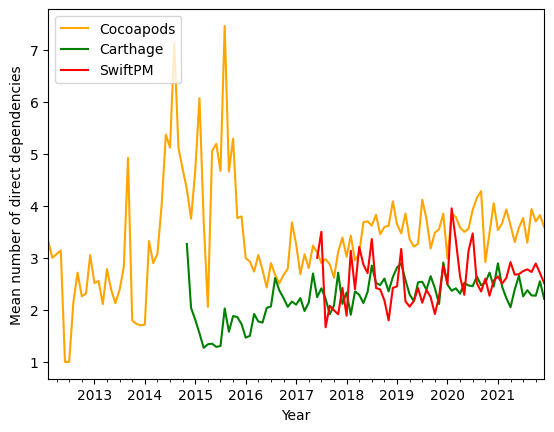

In [19]:
co_data_dep = dependencies[(dependencies['type'] == 'cocoapods') & (dependencies['year'] != '2022')].groupby(['month'])['dependency_count'].mean()
ca_data_dep = dependencies[(dependencies['type'] == 'carthage') & (dependencies['year'] != '2022')].groupby(['month'])['dependency_count'].mean()
sw_data_dep = dependencies[(dependencies['type'] == 'swiftpm') & (dependencies['year'] != '2022')].groupby(['month'])['dependency_count'].mean()

results1 = pd.DataFrame({'Cocoapods': co_data_dep, 'Carthage': ca_data_dep, 'SwiftPM': sw_data_dep})

results1.plot(color = ['orange', 'green', 'red'])
plt.legend(loc='upper left')
plt.xlabel("Year")
plt.ylabel("Mean number of direct dependencies")
plt.tight_layout

plt.savefig('plot_mean_number_of_depenencies_per_month_per_package_manager.pdf', bbox_inches = "tight")

As an additional plot the mean number of direct dependencies for all library versions without distinguishing between package managers: 

<AxesSubplot: xlabel='month'>

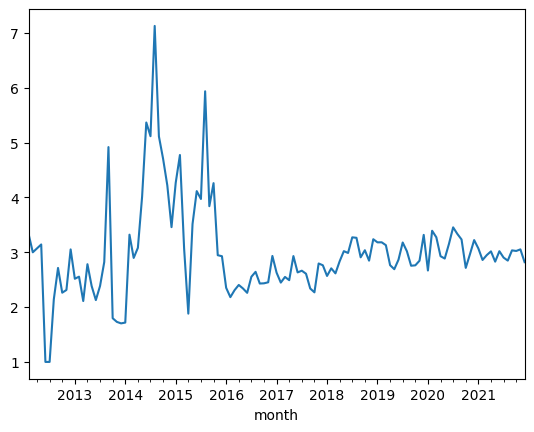

In [20]:
dependencies[(dependencies['year'] != '2022')].groupby(['month'])['dependency_count'].mean().plot()

Another additional plot shows the mean number of dependents for library versions added each month. 

Text(0, 0.5, 'Mean number of dependents')

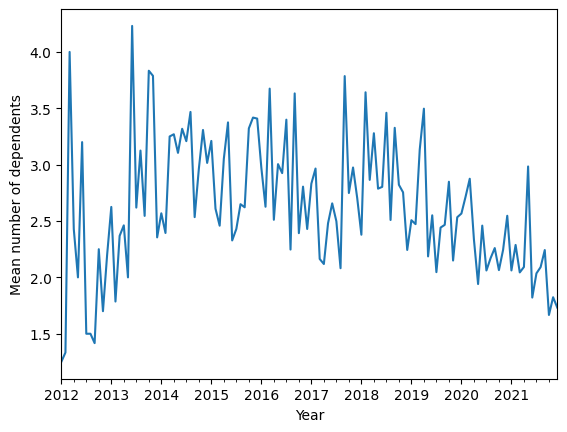

In [21]:
dep_no_type[(dep_no_type['month'].between('2012.01.01', '2021.12.31')) & (dep_no_type['dependent_count'] > 0)].groupby(['month'])['dependent_count'].mean().plot()

plt.xlabel("Year")
plt.ylabel("Mean number of dependents")

Lastly we plot the total number of dependencies for each month. For this we first read in csv file with information on all analysed library versions with dependencies that includes the number of total dependencies. Total dependencies = direct + indirect dependencies. 

Query used: 

    match 
        (a:App)-[:IS]->(l:Library)-[:LIBRARY_DEPENDS_ON*1..10]->(vl:Library)
    return 
        a.name as library_name, 
        a.tag as tag, 
        a.timestamp as timestamp,
        count(distinct vl) as total_dependencies_count

In [22]:
total_dependencies_data = pd.read_csv('total_dependencies_count.csv')

In [23]:
total_dependencies_data['date'] = total_dependencies_data['timestamp'].apply(datetime.datetime.fromtimestamp)
total_dependencies_data['month'] = total_dependencies_data['date'].dt.to_period('M')
total_dependencies_data['year'] = total_dependencies_data['date'].dt.to_period('Y')

total_dependencies_data = total_dependencies_data[total_dependencies_data['year'] != '2022']

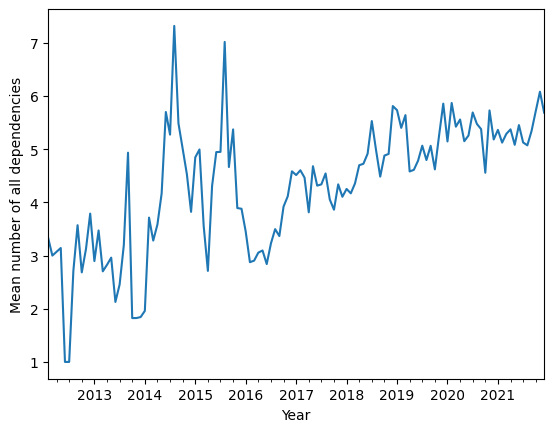

In [24]:
total_dependencies_data[(total_dependencies_data['month'].between('2012.01.01', '2021.12.31')) & (total_dependencies_data['total_dependencies_count'] > 0)].groupby(['month'])['total_dependencies_count'].mean().plot()

plt.xlabel("Year")
plt.ylabel("Mean number of all dependencies")

plt.savefig('plot_mean_number_of_all_dependencies_per_month.pdf', bbox_inches = "tight")